# Function Preparation

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def load_and_split_data(file_path, split_size, is_dropping_diagnosis):
    patients = pd.read_csv(file_path, low_memory=False)
    # patients = patients.drop(columns='flag')

    if is_dropping_diagnosis:
        patients = patients.drop(columns=['diagnosis'])

    patients_enc = pd.get_dummies(patients)

    X = patients_enc.drop(columns='has_apnea')
    y = patients_enc['has_apnea']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=42)

    return X_train, X_test, y_train, y_test

def run_model(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier()

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Get probability predictions
    y_proba = clf.predict_proba(X_test)[:,1]

    return clf, y_proba, accuracy

def calculate_feature_importance(clf, xtr):
    # Get the feature importance
    feature_importances = clf.feature_importances_
    feature_names = xtr.columns

    # Sort the features by importance
    sorted_idx = feature_importances.argsort()

    return sorted_idx, feature_names

def plot_calculated_feature_importances(clf, xtrain, title):
    # Get feature importance
    sorted_d, f_names = calculate_feature_importance(clf, xtrain)

    # Plot the top 20 features
    top_20_id = sorted_d[-20::]
    top_20_features = f_names[top_20_id]
    plot_top_features(clf.feature_importances_[top_20_id], top_20_features, title)

def plot_top_features(feature_ids, feature_names, title):
    plt.figure(figsize=(12, 5))
    bars = plt.bar(feature_names, feature_ids)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval*100:.2f}%', va='bottom', ha='center', fontsize=8)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

def plot_probability_distribution(probs, title):
    plt.hist(probs, bins=20)
    plt.title(title)
    plt.show()


# Random Forest Classifier Model

In [2]:
title = "Sleep Apnea classifier probability distribution"
test_split_size = 0.35

# Run model with diagnosis column
xtr_d, xte_d, ytr_d, ydte_d = load_and_split_data('patient_data_apnea_mix.csv', test_split_size, False)
clf_d, probs_d, accuracy_d = run_model(xtr_d, xte_d, ytr_d, ydte_d)

# Run model without diagnosis column
xtr, xte, ytr, yte = load_and_split_data('patient_data_apnea_mix.csv', test_split_size, True)
clf_no_d, probs_no_d, accuracy_no_d = run_model(xtr, xte, ytr, yte)

# Plot the model prediction accuracy and probability distribution

Accuracy with diagnosis column: 0.9997904143127971


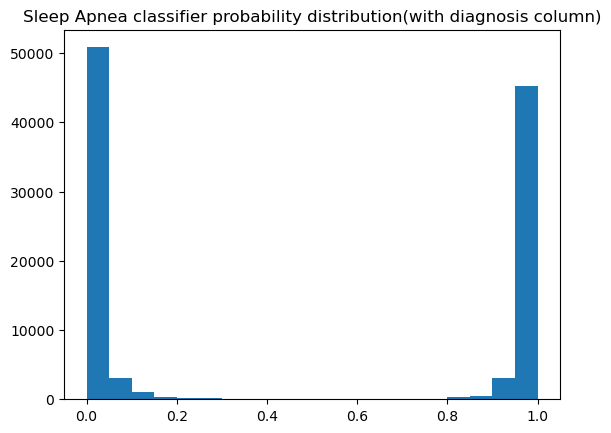

Accuracy without diagnosis column: 0.9947508311977822


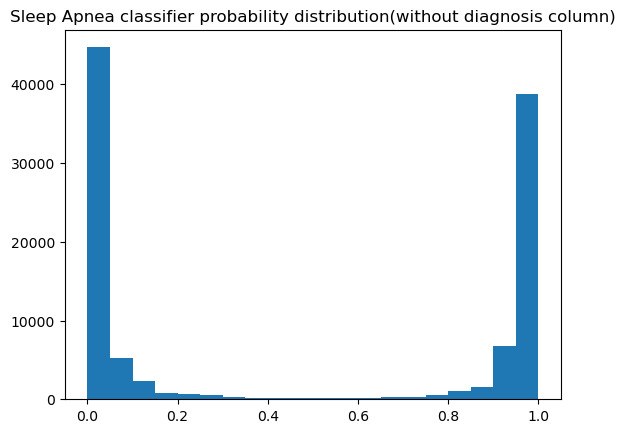

In [3]:
print("Accuracy with diagnosis column:", accuracy_d)
plot_probability_distribution(probs_d, title + "(with diagnosis column)")

print("Accuracy without diagnosis column:", accuracy_no_d)
plot_probability_distribution(probs_no_d, title + "(without diagnosis column)")

# Find features that matter the most & graph them.

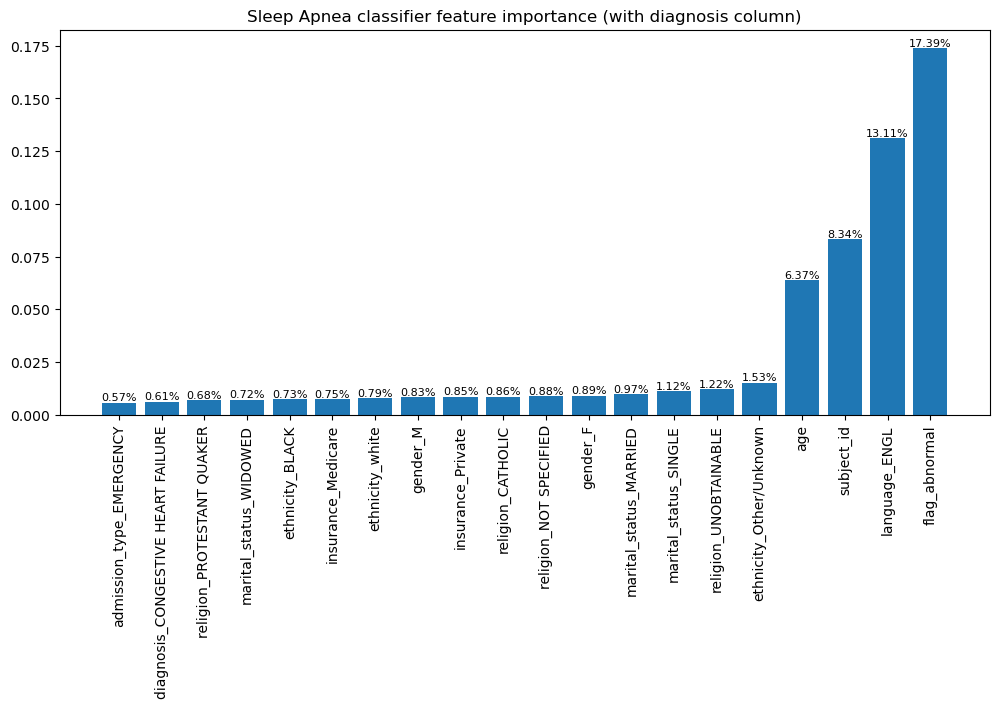

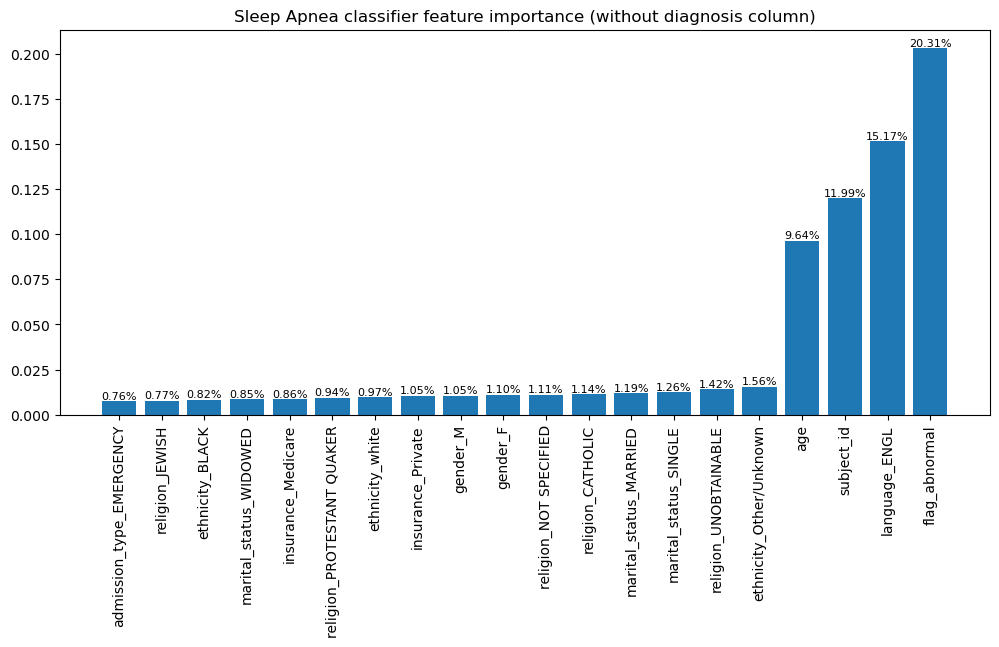

In [4]:
title = "Sleep Apnea classifier feature importance "

# Plot the probabilities and feature importance
plot_calculated_feature_importances(clf_d, xtr_d, title + "(with diagnosis column)")
plot_calculated_feature_importances(clf_no_d, xtr, title + "(without diagnosis column)")

# TODO: Consider clustering the data to see if there are any patterns

# TODO: Consider fine tuning model

# TODO: Evaluate the model

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     55659
           1       0.99      1.00      0.99     49310

    accuracy                           0.99    104969
   macro avg       0.99      0.99      0.99    104969
weighted avg       0.99      0.99      0.99    104969



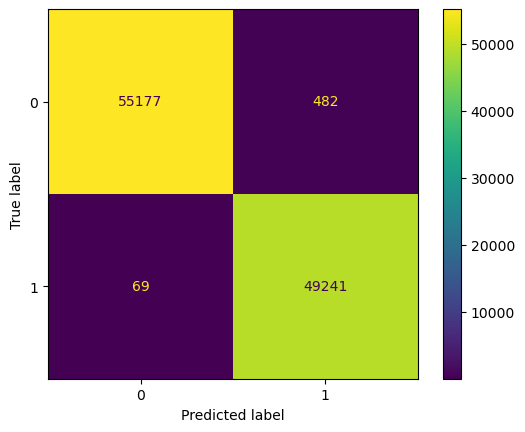

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf_no_d.predict(xte)
cm = confusion_matrix(yte, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

from sklearn.metrics import classification_report

print(classification_report(yte, y_pred))

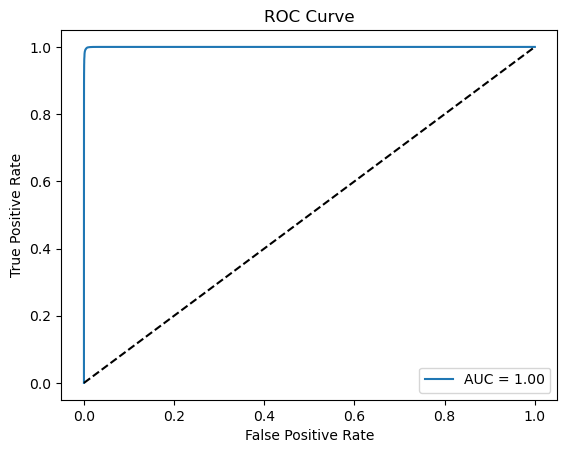

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(yte, probs_no_d)
auc = roc_auc_score(yte, probs_no_d)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_no_d, xtr, ytr, cv=5, scoring='accuracy')
print("Cross-validated accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validated accuracy scores: [0.99322886 0.99284414 0.99369037 0.99351082 0.99304914]
Mean accuracy: 0.9932646656766444
